# Simulation of star PSF curve and Test optimization function

- author : Sylvie Dagoret-Campagne
- afflilation : LAL-CNRS
- creation date : December 13th 2019
- update :December 15th 2019



In [131]:
import os
import re
import numpy as np

In [132]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [133]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [134]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import Table

In [135]:
from math import ceil,floor
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.modeling.functional_models import Moffat2D

In [136]:
from numpy.core._multiarray_umath import ndarray
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

In [137]:
from scipy import interpolate

In [138]:
from scipy import optimize
from scipy.optimize import minimize

In [139]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(10,10)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

# Definitions

## Addition includes

In [140]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [141]:
from FeaturesExtractor.config import set_logger
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

## Function

# Configuration

In [142]:
IMAGE_SIZE=50

In [143]:
THETA=45.*np.pi/180.

In [144]:
SIGMA_X=10
SIGMA_Y=10
#SIGMA_Y=6

In [145]:
X0=IMAGE_SIZE/2
Y0=IMAGE_SIZE/2

In [146]:
a=0.5*((np.cos(THETA)/SIGMA_X)**2+(np.sin(THETA)/SIGMA_Y)**2)

In [147]:
b=-np.sin(2*THETA)/4.*(-1./SIGMA_X**2 + 1./SIGMA_Y**2)

In [148]:
c=0.5*((np.sin(THETA)/SIGMA_X)**2+(np.cos(THETA)/SIGMA_Y)**2)

In [149]:
A=1000.

In [150]:
#sat_fraction=0   # no saturation
sat_fraction=0.5  # saturation

In [151]:
FLAG_MOFFAT2D=False

In [152]:
ALPHA=-1         # exponent of the Moffat

In [153]:
if FLAG_MOFFAT2D:
    psf_title="psf : moffat, "
else:
    psf_title="psf : gaussian, "

In [154]:
def PSF(x,y):
    if FLAG_MOFFAT2D:
        M=A* np.power(1+ a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) +c*(y-Y0)**2,ALPHA)
    else:
        M=A*np.exp(-(a*(x-X0)**2 + 2*b*(y-Y0)*(x-X0) + c*(y-Y0)**2))
        
        
    if sat_fraction==0:
        return M
    else:
        Smax=sat_fraction*A
        S=np.where(M<Smax,M,Smax)
        return S

# Start

In [155]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Generate the image

## Background

In [156]:
background=np.random.normal(0,10,(IMAGE_SIZE,IMAGE_SIZE))

In [157]:
background-=background.min()

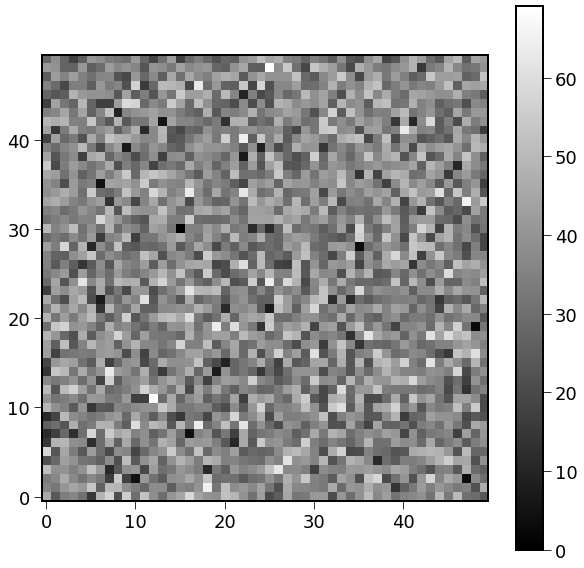

In [158]:
im=plt.imshow(background,origin="lower",cmap="gray")
plt.colorbar(im)

## Signal

In [159]:
X=np.arange(IMAGE_SIZE)
Y=np.arange(IMAGE_SIZE)

In [160]:
XX, YY = np.meshgrid(X, Y)

In [161]:
signal=PSF(XX,YY)

In [162]:
image=signal+background

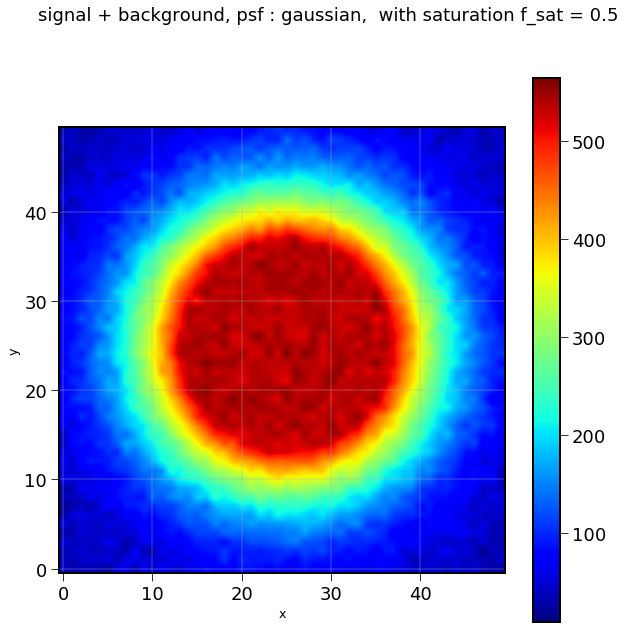

In [163]:
im=plt.imshow(image,origin="lower",interpolation='bilinear',cmap="jet")
plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')
title = "signal + background, " + psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)
plt.grid()

Text(0.5, 0.98, 'signal + background, psf : gaussian,  with saturation f_sat = 0.5')

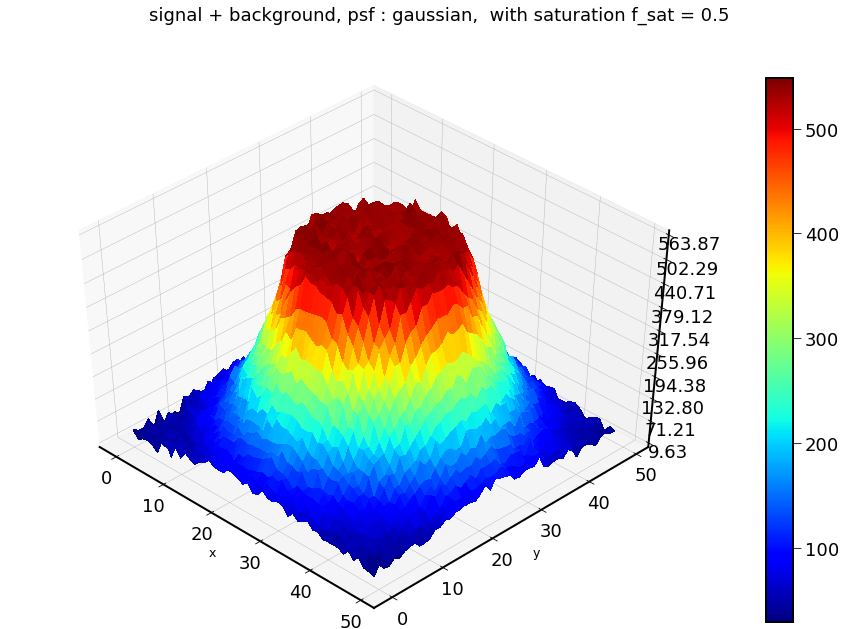

In [164]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
surf=ax.plot_surface(XX, YY, image, cmap="jet", rstride=1, cstride=1 ,antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.colorbar(surf)




title = "signal + background, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title)

# Compute the Hessian

In [165]:
lambda_plus, lambda_minus, theta = hessian_and_theta(image,margin_cut=1)

In [166]:
Nx=lambda_plus.shape[1]
Ny=lambda_plus.shape[0]

In [167]:
PadX=int((IMAGE_SIZE-Nx)/2)
PadY=int((IMAGE_SIZE-Ny)/2)

In [168]:
lambda_plus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))
lambda_minus_new=np.zeros((IMAGE_SIZE,IMAGE_SIZE))

In [169]:
lambda_plus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_plus
lambda_minus_new[PadY:IMAGE_SIZE-PadY, PadX:IMAGE_SIZE-PadX]= lambda_minus

Text(0.5, 0.98, 'Lambda_plus, psf : gaussian,  with saturation f_sat = 0.5')

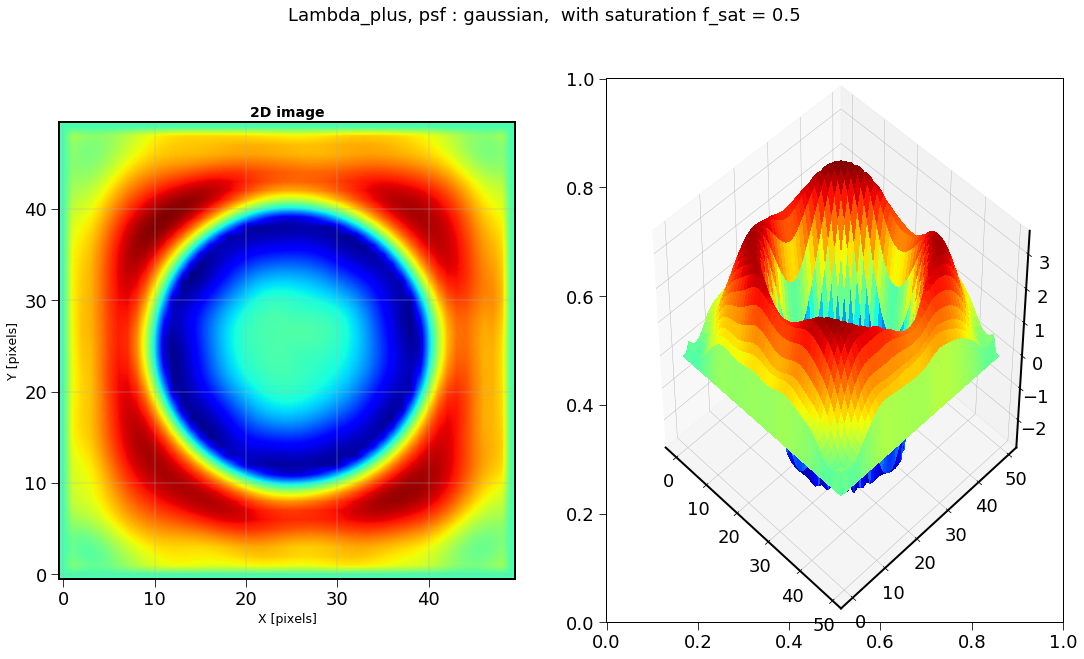

In [170]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_new, origin="lower", interpolation='bilinear',cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.view_init(45, -45)
ax2.plot_surface(XX, YY, lambda_plus_new,rstride=1, cstride=1 ,antialiased=False,cmap=plt.cm.jet)
        

# fig.tight_layout()
title = "Lambda_plus, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)


Text(0.5, 0.98, 'Lambda_minus, psf : gaussian,  with saturation f_sat = 0.5')

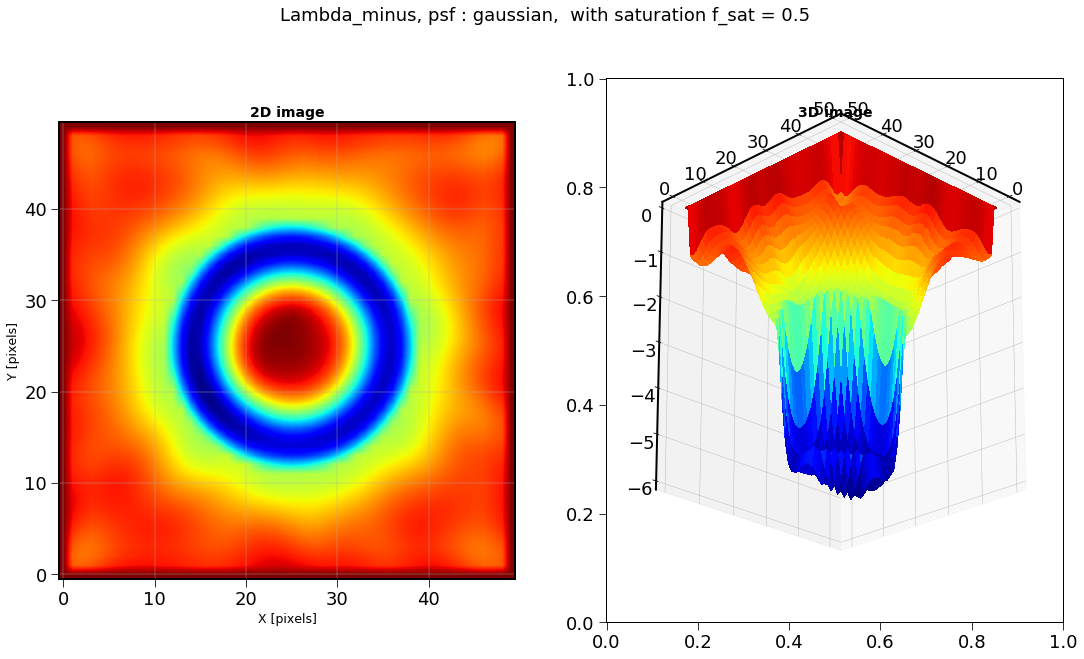

In [171]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_minus_new, origin="lower", interpolation='bilinear',cmap=plt.cm.jet)
ax1.set_title('2D image', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('3D image', fontsize=14)
ax2.view_init(-20, 45)
ax2.plot_surface(XX, YY, lambda_minus_new, rstride=1,  cstride=1 ,antialiased=False,cmap=plt.cm.jet)
        
title = "Lambda_minus, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"
plt.suptitle(title,fontsize=18)

# detect the edges

In [172]:
lambda_plus_edge=feature.canny(lambda_plus_new, sigma=5)
lambda_minus_edge=feature.canny(lambda_minus_new, sigma=5)

Text(0.5, 0.98, 'Canny edge detection, psf : gaussian,  with saturation f_sat = 0.5')

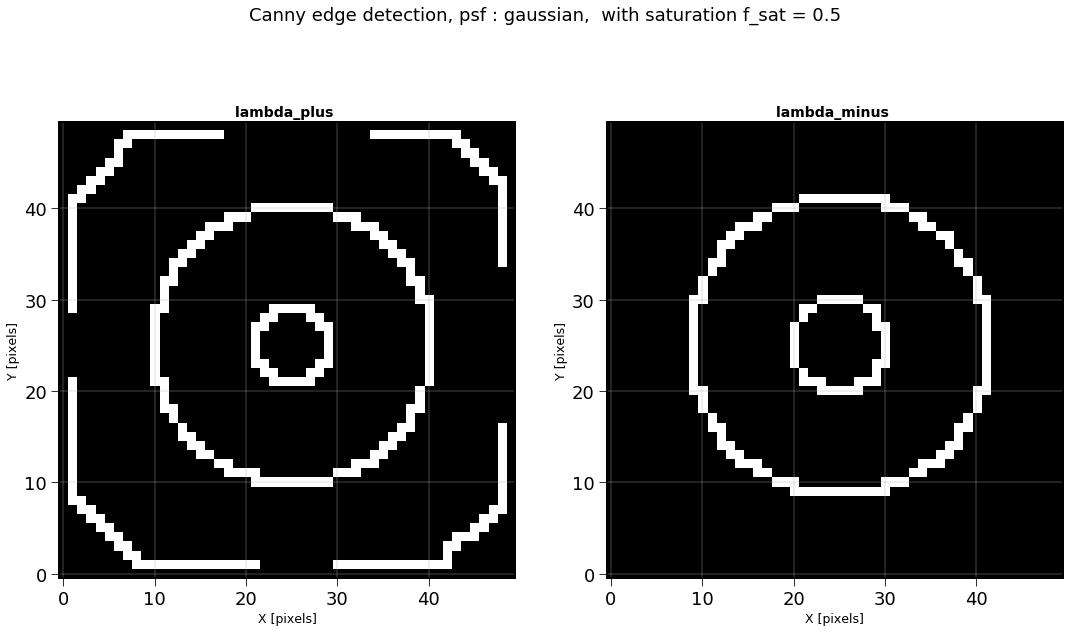

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))


ax1.imshow(lambda_plus_edge, origin="lower", cmap=plt.cm.gray)
ax1.set_title('lambda_plus ', fontsize=14)
ax1.grid(True)
ax1.set_xlabel('X [pixels]')
ax1.set_ylabel('Y [pixels]')

ax2.imshow(lambda_minus_edge, origin="lower", cmap=plt.cm.gray)
ax2.set_title('lambda_minus ', fontsize=14)
ax2.grid(True)
ax2.set_xlabel('X [pixels]')
ax2.set_ylabel('Y [pixels]')
        
title="Canny edge detection, "+ psf_title
if sat_fraction > 0:
    title= title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + " without saturation"    
    
# fig.tight_layout()
plt.suptitle(title,fontsize=18)

# Minimisation - Optimisation
https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

## Interpolation

In [174]:
f_img = interpolate.interp2d(XX, YY, image, kind='linear')

In [175]:
f_lambda_plus_plus = interpolate.interp2d(XX, YY, lambda_plus_new, kind='linear')

In [176]:
f_lambda_plus_moins = interpolate.interp2d(XX, YY, -lambda_plus_new, kind='linear')

In [177]:
f_lambda_minus_plus = interpolate.interp2d(XX, YY, lambda_minus_new, kind='linear')

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=52,53 m=2500 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [178]:
f_lambda_minus_moins = interpolate.interp2d(XX, YY, -lambda_minus_new, kind='linear')

## Selection of array on which array is done the minimisation

In [179]:
title = "lambda_minus (plus)"
thelambdaarr= lambda_minus_new
def function_opt(x):
    return f_lambda_minus_plus(x[0],x[1])[0]

In [180]:
#title = "lambda_minus (moins)"
#thelambdaarr= -lambda_minus_new
#def function_opt(x):
#    return f_lambda_minus_moins(x[0],x[1])[0]

In [181]:
#title = "lambda_plus (plus)"
#thelambdaarr= lambda_plus_new
#def function_opt(x):
#    return f_lambda_plus_plus(x[0],x[1])[0]

In [182]:
#title = "lambda_plus (moins)"
#thelambdaarr= - lambda_plus_new
#def function_opt(x):
#    return f_lambda_plus_moins(x[0],x[1])[0]

In [183]:
if sat_fraction > 0:
    title= title + psf_title + " with saturation f_sat = {}".format(sat_fraction)
else:
    title= title + psf_title +" without saturation"  

## Test many optimisation algorithm:

Global optimization aims to find the global minimum of a function within given bounds, in the presence of potentially many local minima. Typically global minimizers efficiently search the parameter space, while using a local minimizer (e.g. minimize) under the hood. SciPy contains a number of good global optimizers. Here we’ll use those on the same objective function, namely the (aptly named) eggholder function:

- SHGO       : simplicial homology global optimization
- DA         : dual_annealing
- DE         : differential_evolution
- BH         : basinhopping
- SHGO_SOBOL : shgo has a second method, which returns all local minima rather than only what it thinks is the global minimum:

In [184]:
bounds = [(0, image.shape[1]), (0, image.shape[1])]

In [185]:
results = dict()
results['shgo'] = optimize.shgo(function_opt, bounds)

In [186]:
results['shgo']

     fun: -5.745553053087855
    funl: array([-5.74555305])
 message: 'Optimization terminated successfully.'
    nfev: 464
     nit: 2
   nlfev: 459
   nlhev: 0
   nljev: 62
 success: True
       x: array([33.93633435, 18.81135741])
      xl: array([[33.93633435, 18.81135741]])

In [187]:
results['DA'] = optimize.dual_annealing(function_opt, bounds)

In [188]:
results['DA']

     fun: -6.684262375176172
 message: ['Maximum number of iteration reached']
    nfev: 4610
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([18.94892086, 16.26249692])

In [189]:
results['DE'] = optimize.differential_evolution(function_opt, bounds)

In [190]:
results['DE']

     fun: -6.684265597635229
     jac: array([-0.00951061, -2.22874297])
 message: 'Optimization terminated successfully.'
    nfev: 1098
     nit: 27
 success: True
       x: array([18.9488964 , 16.26249692])

In [191]:
results['BH'] = optimize.basinhopping(function_opt, bounds)

In [192]:
results['BH']

                        fun: 0.0
 lowest_optimization_result:       fun: 0.0
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 0., 50.,  0., 50.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 606
                        nit: 100
                       njev: 101
                          x: array([ 0., 50.,  0., 50.])

In [193]:
results['shgo_sobol'] = optimize.shgo(function_opt, bounds, n=200, iters=5,sampling_method='sobol')

In [194]:
results['shgo_sobol'] 

     fun: -6.684265611078603
    funl: array([-6.68426561, -6.68426561, -6.6093276 , -6.21019609, -6.15688848,
       -6.10638724, -6.00730577, -6.00297414, -5.99998988, -5.9811388 ,
       -5.97651385, -5.93165324, -5.89947218, -5.89700663, -5.89700663,
       -1.41946981, -1.41946979, -1.29502255, -1.2931064 , -1.26919318])
 message: 'Optimization terminated successfully.'
    nfev: 7519
     nit: 5
   nlfev: 6519
   nlhev: 0
   nljev: 881
 success: True
       x: array([18.9488964 , 16.26249692])
      xl: array([[18.9488964 , 16.26249692],
       [18.94889651, 16.26249692],
       [31.54296808, 16.26249692],
       [15.29909196, 20.67397979],
       [20.37070452, 14.90992208],
       [28.63033402, 14.90992207],
       [15.29909195, 29.46219012],
       [35.55897948, 22.44169462],
       [32.46475316, 33.19855005],
       [13.71072226, 24.17740536],
       [16.65913806, 32.22999861],
       [35.55897947, 27.99999982],
       [20.37070449, 35.18382252],
       [28.63033402, 35.183801

## Plot the results

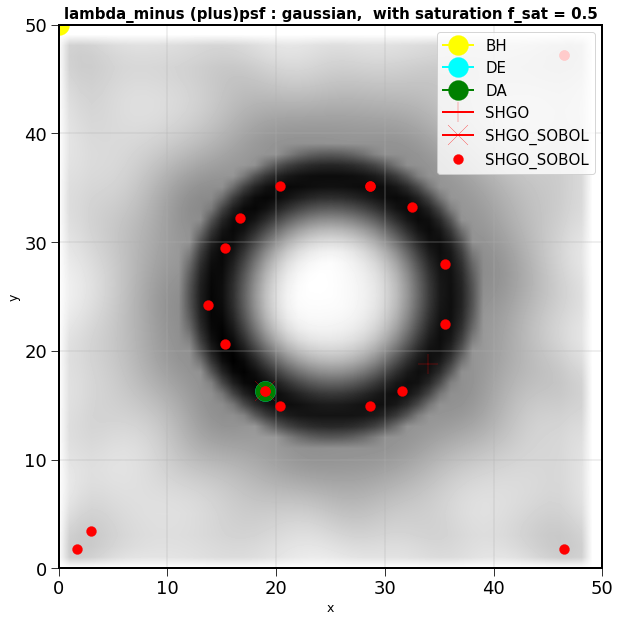

In [195]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(thelambdaarr, interpolation='bilinear', origin='lower',cmap='gray')

ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None, ms=20,label=" "):
    ax.plot(res.x[0], res.x[1], marker=marker, color=color, ms=ms,label=label)

plot_point(results['BH'], color='yellow', label="BH")  # basinhopping           - yellow
plot_point(results['DE'], color='cyan', label="DE")  # differential_evolution - cyan
plot_point(results['DA'], color='green', label="DA")  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+',ms=20,label="SHGO")
plot_point(results['shgo_sobol'], color='r', marker='x',ms=20,label="SHGO_SOBOL")
for i in range(results['shgo_sobol'].xl.shape[0]):
    if i==0:     
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=10,label="SHGO_SOBOL")
    else:
        ax.plot(results['shgo_sobol'].xl[i, 0],results['shgo_sobol'].xl[i, 1],'ro', ms=10)

ax.set_xlim([0, image.shape[1]])
ax.set_ylim([0, image.shape[0]])
ax.legend(loc="upper right")  
ax.grid()
plt.title(title)
plt.show()